## SMM Estimation of Theories of Expectation Formation with Inflation Expectation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import types
from numba.typed import Dict,List
import pandas as pd
from statsmodels.tsa.api import AutoReg as AR
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('ggplot')

## figure config

lw = 4  #line width


## Model

In [2]:
from SMMEst import SimAR1, SimUCSV,ObjGen, ObjWeight,ParaEst,type_list

from SMMEst import StickyExpectationAR, StickyExpectationSV
from SMMEst import NoisyInformationAR, NoisyInformationSV
from SMMEst import DiagnosticExpectationAR, DiagnosticExpectationSV
from SMMEst import DENIHybridAR, DENIHybridSV


In [3]:
## create some fake parameters and data to initialize model class
### not used for estimation

## AR1 parameters
ρ0,σ0 = 0.98, 0.10

history0 = SimAR1(ρ0,
                  σ0,
                  200)
real_time0 = history0[11:-2]

realized0 = history0[12:-1]

### UCSV inflation

p0_fake = 0 ## initial permanent component
γ_fake = 0.1 ## size of shock to the volatility
σs_now_fake = [0.2,0.3] ## volatility of permanent and transitory component

ucsv_fake = SimUCSV(γ_fake,
                    nobs = 200,
                    p0 = p0_fake,
                    )

xx_real_time,xx_p_real_time,vol_p_real_time,vol_t_real_time = ucsv_fake

xx_realized = xx_real_time[1:-1]

xx_real_time= np.array([xx_real_time,
                        xx_p_real_time,
                        vol_p_real_time,
                        vol_t_real_time]
                      )[:,0:-2]

### Sticky Expectation (SE) + AR1

### Sticky Expectation (SE) + SV

In [4]:
## initialize the ar instance
sear0 = StickyExpectationAR(exp_para = np.array([0.2]),
                            process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

sear0.GetRealization(realized0)

In [5]:
## initialize the sv instance
sesv0 = StickyExpectationSV(exp_para = np.array([0.3]),
                           process_para = np.array([0.05]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

sesv0.GetRealization(xx_realized)

### Noisy Information (NI) + AR1


### Noisy Information (NI) + SV



In [6]:
## initialize the ar instance
niar0 = NoisyInformationAR(exp_para = np.array([0.1,0.2]),
                            process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

niar0.GetRealization(realized0)

In [7]:
## initial a sv instance
nisv0 = NoisyInformationSV(exp_para = np.array([0.3,0.2]),
                           process_para = np.array([0.1]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

nisv0.GetRealization(xx_realized)

###  Diagnostic Expectation(DE) + AR1

###  Diagnostic Expectation(DE) + SV

In [8]:
## initialize the ar instance
dear0 = DiagnosticExpectationAR(exp_para = np.array([0.5,0.2]),
                                process_para = np.array([ρ0,σ0]),
                                real_time = real_time0,
                                history = history0,
                                horizon = 1)

dear0.GetRealization(realized0)

In [9]:
## initial a sv instance
desv0 = DiagnosticExpectationSV(exp_para = np.array([0.3,0.2]),
                               process_para = np.array([0.05]),
                               real_time = xx_real_time,
                               history = xx_real_time) ## history does not matter here, 

## get the realization 

desv0.GetRealization(xx_realized)

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + AR1

###  Diagnostic Expectation and Noisy Information Hybrid(DENI) + SV



In [10]:
## initialize the ar instance
deniar0 = DENIHybridAR(exp_para = np.array([0.1,0.3]),
                       process_para = np.array([ρ0,σ0]),
                            real_time = real_time0,
                            history = history0,
                            horizon = 1)

deniar0.GetRealization(realized0)

In [11]:
## initial a sv instance
denisv0 = DENIHybridSV(exp_para = np.array([0.1,0.2]),
                           process_para = np.array([0.05]),
                           real_time = xx_real_time,
                           history = xx_real_time) ## history does not matter here, 

## get the realization 

denisv0.GetRealization(xx_realized)

## Data Estimation  

### Prepare the data 

#### Real-time Inflation data

In [12]:
import pandas as pd
real_time_index = pd.read_excel('../OtherData/RealTimeData/RealTimeInfQ.xlsx')

real_time_index.index = pd.to_datetime(real_time_index['DATE'],format='%Y%m%d')
real_time_index = real_time_index.drop(columns=['DATE'])

## turn index into yearly inflation
#real_time_index = pd.concat([real_time_cpic,real_time_cpi], join='inner', axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100  ## year-over-year inflation, standard 
real_time_inf = real_time_inf.dropna()

#### Inflation data 

In [13]:
###############
## monthly ### 
##############

InfM = pd.read_stata('../OtherData/InfM.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')

InfM.index = pd.DatetimeIndex(dateM,
                              freq='infer')

###############
## quarterly ##
###############

InfQ = InfM.resample('Q').last()
dateQ = pd.to_datetime(InfQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)

InfQ.index = pd.DatetimeIndex(dateQ_str,freq='infer')

###########################
#keep only needed variables 
############################

InfM = InfM[['Inf1y_CPIAU',
             'Inf1yf_CPIAU']]

InfQ = InfQ[['Inf1y_CPICore',
            'Inf1yf_CPICore']]

#### Expectation data

In [14]:
## expectation data from SPF 

PopQ = pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]
dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')
dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)
SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')

## expectation data from SCE
PopM = pd.read_stata('../SurveyData/InfExpM.dta')
PopM = PopM[-PopM.date.isnull()]
dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')
dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)

SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var',
              'SCE_Mean_rd','SCE_FE_rd','SCE_Disg_rd','SCE_Var_rd']].dropna(how='any')

<Axes: title={'center': 'SCE Expectations'}, xlabel='date'>

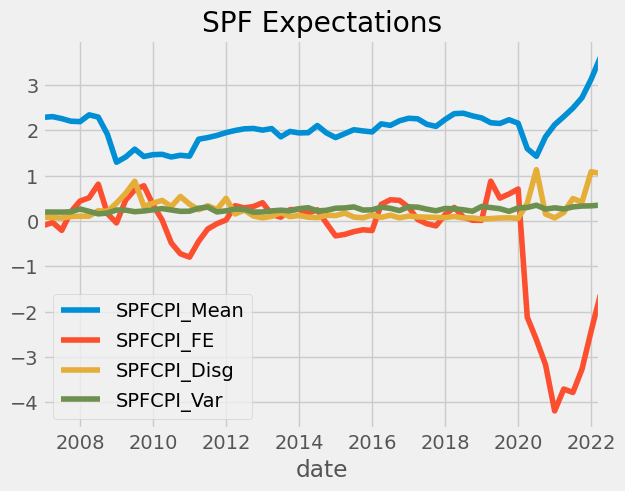

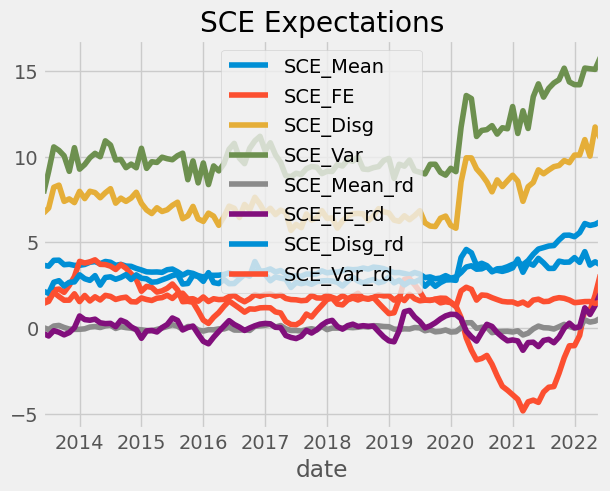

In [15]:
## plot times eries of 

SPFCPI.plot(title='SPF Expectations')

SCECPI.plot(title='SCE Expectations')

In [16]:
import datetime

## tempoary date used to check the data moments 

end_date_late = datetime.datetime(2023, 3, 30)
end_date_early = datetime.datetime(2020, 4, 30)

## we only focus on 4th quarter observations from SPF 
SPFCPI = SPFCPI[SPFCPI.index.quarter==4]

In [17]:
print('SCE\n')
print(SCECPI.mean())
print('sample period, begin at '+str(SCECPI.index[0])+', and end at '+str(SCECPI.index[-1]))
print('\n')
print('before 2020\n')
print(SCECPI[SCECPI.index<end_date_early].mean())

print('\n')

print('SPF (only in the forth quarter)\n')
print(SPFCPI.mean())
print('sample period, begin at '+str(SPFCPI.index[0])+', and end at '+str(SPFCPI.index[-1]))
print('\n')

print('before 2020\n')
print(SPFCPI[SPFCPI.index<end_date_early].mean())

SCE

SCE_Mean       3.62
SCE_FE         0.86
SCE_Disg       7.46
SCE_Var       10.55
SCE_Mean_rd    0.01
SCE_FE_rd     -0.00
SCE_Disg_rd    3.04
SCE_Var_rd     1.73
dtype: float64
sample period, begin at 2013-06-01 00:00:00, and end at 2022-06-01 00:00:00


before 2020

SCE_Mean       3.34
SCE_FE         1.78
SCE_Disg       6.88
SCE_Var        9.69
SCE_Mean_rd   -0.00
SCE_FE_rd      0.06
SCE_Disg_rd    2.83
SCE_Var_rd     1.76
dtype: float64


SPF (only in the forth quarter)

SPFCPI_Mean    2.02
SPFCPI_FE     -0.32
SPFCPI_Disg    0.18
SPFCPI_Var     0.22
dtype: float64
sample period, begin at 2007-10-01 00:00:00, and end at 2021-10-01 00:00:00


before 2020

SPFCPI_Mean   1.97
SPFCPI_FE     0.12
SPFCPI_Disg   0.16
SPFCPI_Var    0.21
dtype: float64


In [18]:
## filter sample period 

## SPF
SPFCPI = SPFCPI[SPFCPI.index<end_date_late]

## SCE
SCECPI = SCECPI[SCECPI.index<end_date_late]

In [19]:
## Combine expectation data and real-time data 

SPF_est= pd.concat([SPFCPI,
                    real_time_inf,
                    InfQ], 
                   join='inner', 
                   axis=1)

SCE_est = pd.concat([SCECPI,
                     real_time_inf,
                     InfM], 
                    join='inner', 
                    axis=1)

#### History data 

In [20]:
## process parameters estimation AR1 
# period filter 
start_t='2000-01-01'
end_t = '2023-4-30'   ## 

######################
### quarterly data ##
#####################

CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]

print('for SPF moments estimation, the sample is between '+str(start_t)+' and '+str(end_t))

###################
### monthly data ##
###################

CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]

print('for SPF moments estimation, the sample is between '+str(start_t)+' and '+str(end_t))

for SPF moments estimation, the sample is between 2000-01-01 and 2023-4-30
for SPF moments estimation, the sample is between 2000-01-01 and 2023-4-30


In [21]:
## history data, the series ends at the same dates with real-time data but startes earlier

st_t_history = '1995-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

## get the quarterly index 
indexQ = CPICQ.index

## get history data quarterly and monthly respectively 
af = indexQ >= st_t_history 
bf = indexQ <=ed_t_SPF
time_filter = np.logical_and(af,bf)
time_filter_idx = indexQ[time_filter]

historyQ = real_time_inf.loc[time_filter_idx]
historyM = real_time_inf.loc[st_t_history:ed_t_SCE]

#### Realization data

In [22]:
## realized 1-year-ahead inflation

realized_CPIC = np.array(SPF_est['Inf1yf_CPICore']) 
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU']) 

#### AR1 parameters 

In [23]:
######################
### quarterly data ##
#####################

CPICQ_demean = CPICQ

ARmodel = AR(CPICQ_demean,lags=[1],trend='n') 
ar_rs = ARmodel.fit()
rhoQ_est = ar_rs.params[0]
if rhoQ_est>1.0:
    rhoQ_est = 1.0
sigmaQ_est = np.sqrt(ar_rs.sigma2) #np.sqrt(sum(ar_rs.resid**2)/(len(CPIM)-1))

###################
### monthly data ##
###################

CPIM_demean = CPIM
ARmodel2 = AR(CPIM_demean,lags=[1],trend='n') ## 12 months of lags!
ar_rs2 = ARmodel2.fit()
rhoM_est = ar_rs2.params[0]
if rhoM_est>1.0:
    rhoM_est = 1.0
sigmaM_est = np.sqrt(ar_rs2.sigma2)  # or np.sqrt(sum(ar_rs2.resid**2)/(len(CPIM)-1))

In [24]:
print('For the sample before', str(end_t))

print('quarterly AR(1) estimates for CPI core:')
print(rhoQ_est)
print(sigmaQ_est)
print('monthly AR(1) estimates for CPI headline:')
print(rhoM_est)
print(sigmaM_est)

For the sample before 2023-4-30
quarterly AR(1) estimates for CPI core:
0.9990788517311803
0.44902036754399954
monthly AR(1) estimates for CPI headline:
0.9921295578296475
0.4601601636280694


In [25]:
FEVar_Q_est = np.array([rhoQ_est**(2*h)*sigmaQ_est**2 for h in range(3)]).sum()
FEVar_M_est = np.array([rhoM_est**(2*h)*sigmaM_est**2 for h in range(12)]).sum()

print('Under the estimated AR(1), 4q-ahead annualized CPI core inflation forecast error should have a variance equal to \n')
print(str(round(FEVar_Q_est,3)))

print('Under the estimated AR(1), 12m-ahead annualized CPI inflation forecast error should have a variance equal to \n')
print(str(round(FEVar_M_est,3)))

Under the estimated AR(1), 4q-ahead annualized CPI core inflation forecast error should have a variance equal to 

0.604
Under the estimated AR(1), 12m-ahead annualized CPI inflation forecast error should have a variance equal to 

2.333


#### Data moments 

In [26]:
#####################################
## preparing data moments
#####################################

## Be careful with the frequency here when computing auto-correlation!!!!!
### SPF: quarters 
### SCE: month

#####################
## Professionals ####
#####################

### inflation moments 

CPIQ_array = np.array(CPICQ)
InfAV_data = np.mean(CPIQ_array-np.mean(CPIQ_array))
InfVar_data = np.var(CPIQ_array)
InfATV_data = np.cov(np.stack( (CPIQ_array[1:],CPIQ_array[:-1]),axis = 0 ))[0,1]
## annual autocovariance

### expectation moments 
exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF = exp_data_SPF.rename(columns={"SPFCPI_Mean": "Forecast", "SPFCPI_FE": "FE",
                            "SPFCPI_Disg":"Disg","SPFCPI_Var":"Var"})

FEs_data = exp_data_SPF['FE']
Disgs_data = exp_data_SPF['Disg']
Vars_data = exp_data_SPF['Var']

FE_data = np.mean(FEs_data)
FEVar_data = np.var(FEs_data)
FEATV_data = np.cov(np.stack( (FEs_data[1:],FEs_data[:-1]),axis = 0))[0,1]  ## one quarter apart 
## annual autocovariance


Disg_data = np.mean(Disgs_data)
DisgVar_data = np.var(Disgs_data)
DisgATV_data = np.cov(np.stack( (Disgs_data[1:],Disgs_data[:-1]),axis = 0))[0,1]
Var_data = np.mean(Vars_data)
VarVar_data = np.var(Vars_data)
VarATV_data = np.cov(np.stack( (Vars_data[1:],Vars_data[:-1]),axis = 0))[0,1]
## annual autocovariance



data_moms_dct_SPF = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)
data_moms_dct_SPF['InfAV'] = InfAV_data
data_moms_dct_SPF['InfVar'] = InfVar_data
data_moms_dct_SPF['InfATV'] = InfATV_data

data_moms_dct_SPF['FE'] = FE_data
data_moms_dct_SPF['FEVar'] = FEVar_data
data_moms_dct_SPF['FEATV'] = FEATV_data
data_moms_dct_SPF['Disg'] = Disg_data
data_moms_dct_SPF['DisgVar'] = DisgVar_data
data_moms_dct_SPF['DisgATV'] = DisgATV_data
data_moms_dct_SPF['Var'] = Var_data
data_moms_dct_SPF['VarVar'] = VarVar_data
data_moms_dct_SPF['VarATV'] = VarATV_data


##########################
### For households 
##########################

#############################################################################################
############!!!!! using "xx_rd" moments only if one wants to control for individual fixed effects
###########################################################################################

control_ind_fe = True

if control_ind_fe:
    exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg_rd','SCE_Var_rd']]
    exp_data_SCE = exp_data_SCE.rename(columns={"SCE_Mean": "Forecast", "SCE_FE": "FE",
                                            "SCE_Disg_rd":"Disg","SCE_Var_rd":"Var"})
else:
    exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
    exp_data_SCE = exp_data_SCE.rename(columns={"SCE_Mean": "Forecast", "SCE_FE": "FE",
                                            "SCE_Disg":"Disg","SCE_Var":"Var"})

## inflation moments 

CPIM_array = np.array(CPIM)

InfAV_data = np.mean(CPIM_array-np.mean(CPIM_array))
InfVar_data = np.var(CPIM_array)
InfATV_data = np.cov(np.stack( (CPIM_array[1:],CPIM_array[:-1]),axis = 0 ))[0,1]

## expectation moments 
FEs_data = exp_data_SCE['FE']
Disgs_data = exp_data_SCE['Disg']
Vars_data = exp_data_SCE['Var']

FE_data = np.mean(FEs_data)
FEVar_data = np.var(FEs_data)
FEATV_data = np.cov(np.stack( (FEs_data[1:],FEs_data[:-1]),axis = 0 ))[0,1]

Disg_data = np.mean(Disgs_data)
DisgVar_data = np.var(Disgs_data)
DisgATV_data = np.cov(np.stack( (Disgs_data[1:],Disgs_data[:-1]),axis = 0))[0,1]
Var_data = np.mean(Vars_data)
VarVar_data = np.var(Vars_data)
VarATV_data = np.cov(np.stack( (Vars_data[1:],Vars_data[:-1]),axis = 0))[0,1]


data_moms_dct_SCE = Dict.empty(
    key_type=types.unicode_type,
    value_type=types.float64,
)
data_moms_dct_SCE['InfAV'] = InfAV_data
data_moms_dct_SCE['InfVar'] = InfVar_data
data_moms_dct_SCE['InfATV'] = InfATV_data
data_moms_dct_SCE['FE'] = FE_data
data_moms_dct_SCE['FEVar'] = FEVar_data
data_moms_dct_SCE['FEATV'] = FEATV_data
data_moms_dct_SCE['Disg'] = Disg_data
data_moms_dct_SCE['DisgVar'] = DisgVar_data
data_moms_dct_SCE['DisgATV'] = DisgATV_data
data_moms_dct_SCE['Var'] = Var_data
data_moms_dct_SCE['VarVar'] = VarVar_data
data_moms_dct_SCE['VarATV'] = VarATV_data

############# need to compute the unconditional moments here 

In [27]:
print('SPF\n')
print(dict(data_moms_dct_SPF))
print('\n')
print('SCE\n')
print(dict(data_moms_dct_SCE))

SPF

{'InfAV': -2.0798216837647487e-07, 'InfVar': 1.2904205322265625, 'InfATV': 1.181345124849721, 'FE': -0.3213231861591339, 'FEVar': 1.4124773740768433, 'FEATV': 0.5772638906109373, 'Disg': 0.17758460342884064, 'DisgVar': 0.019725238904356956, 'DisgATV': 0.010448096417085734, 'Var': 0.2238996370060919, 'VarVar': 0.0011738680344536632, 'VarATV': 0.0005011648454049147}


SCE

{'InfAV': -2.3841858265427618e-08, 'InfVar': 3.281146764755249, 'InfATV': 3.187548798794781, 'FE': 0.8605587482452393, 'FEVar': 4.476667881011963, 'FEATV': 4.437022764080702, 'Disg': 3.044595718383789, 'DisgVar': 0.26631271839141846, 'DisgATV': 0.21191870408380434, 'Var': 1.726943850517273, 'VarVar': 0.03548220172524452, 'VarATV': 0.0140815396945108}


#### model moments 

In [28]:
fire_ar_mom_dct = {'InfAV':0.0,
           'InfVar':r'$\sigma^2_\omega/(1-\rho^2)$',
           'InfATV':r'$\rho\sigma^2_\omega/(1-\rho^2)$',
           'FE':0.0,
           'FEVar':r'$\sigma^2_\omega$',
           'FEATV':0.0,
           'Disg':0.0,
           'DisgVar':0.0,
           'DisgATV':0.0,
           'Var':r'$\sigma^2_\omega$',
            'VarVar':0.0,
            'VarATV':0.0
           }

fire_ar_mom = pd.DataFrame([dict(fire_ar_mom_dct)])
fire_ar_mom.index = ['FIRE+AR']


fire_sv_mom_dct = {'InfAV':0.0,
           'InfVar':'N/A',
           'InfATV':'N/A',
           'FE':0.0,
           'FEVar':r'$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$',
           'FEATV':0.0,
           'Disg':0.0,
           'DisgVar':0.0,
           'DisgATV':0.0,
           'Var':r'$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$',
            'VarVar':'>0',
            'VarATV':'>0'
           }

fire_sv_mom = pd.DataFrame([dict(fire_sv_mom_dct)])
fire_sv_mom.index = ['FIRE+SV']


## these moments have not been used yet 
## need to make sure all is correct 

sear_mom_dct = {'InfAV':0.0,
           'InfVar':r'$\sigma^2_\omega/(1-\rho^2)$',
           'InfATV':r'$\rho\sigma^2\omega/(1-\rho^2)$',
           'FE':0.0,
           'FEVar':r'$\lambda^2\sigma^2/(1-(1-\lambda)^2\rho^2)$',
           'FEATV':r'$(1-\lambda)\rho\text{FEVar}$',
           'Disg':0.0,
           'DisgVar':0.0,
           'DisgATV':0.0,
           'Var':r'$\sigma^2$',
            'VarVar':0.0,
            'VarATV':0.0
           }

sear_mom = pd.DataFrame([sear_mom_dct])
sear_mom.index = ['SE+AR']

In [29]:
## data_moments 


data_mom_SPF = pd.DataFrame([dict(data_moms_dct_SPF)])
data_mom_SPF.index = ['SPF']
data_mom_SCE = pd.DataFrame([dict(data_moms_dct_SCE)])
data_mom_SCE.index = ['SCE']

data_mom_df = pd.concat([data_mom_SPF,
                         data_mom_SCE,
                         fire_ar_mom,
                        fire_sv_mom])

data_mom_df = data_mom_df.applymap(lambda x: round(x, 3) 
                                   if isinstance(x, (int, float)) else x)


### keep only selected moments 

data_mom_df = data_mom_df.drop(columns=['FEATV',
                                        'DisgVar',
                                        'DisgATV',
                                        'VarVar',
                                        'VarATV'])

data_mom_df.T.to_excel('tables/data_moments.xlsx')
data_mom_df.T

,SPF,SCE,FIRE+AR,FIRE+SV
InfAV,-0.00,-0.00,0.00,0.00
InfVar,1.29,3.28,$\sigma^2_\omega/(1-\rho^2)$,N/A
InfATV,1.18,3.19,$\rho\sigma^2_\omega/(1-\rho^2)$,N/A
FE,-0.32,0.86,0.00,0.00
FEVar,1.41,4.48,$\sigma^2_\omega$,$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$
Disg,0.18,3.04,0.00,0.00
Var,0.22,1.73,$\sigma^2_\omega$,$\bar\sigma^2_{\eta}+\bar\sigma^2_{z}$


### Data moments

In [30]:
## real time and history 

################
## quarterly ###
#################

real_time_Q_ar = np.array(SPF_est['RTCPICore'])
history_Q_ar = np.array(historyQ['RTCPICore'])
process_paraQ_est_ar = np.array([rhoQ_est,sigmaQ_est])

##############
## monthly ###
#############

real_time_M_ar = np.array(SCE_est['RTCPI'])
history_M_ar = np.array(historyM['RTCPI'])

process_paraM_est_ar = np.array([rhoM_est,
                                 sigmaM_est])

#### SV  parameters and data  

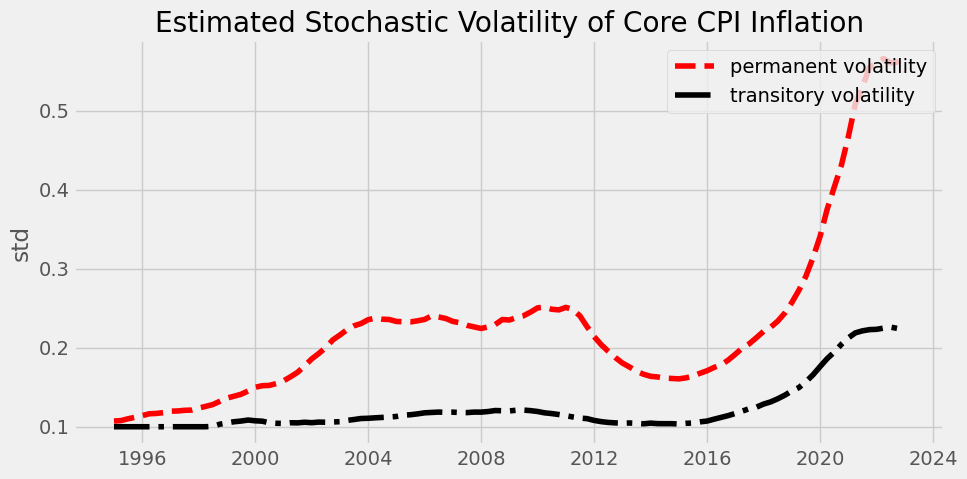

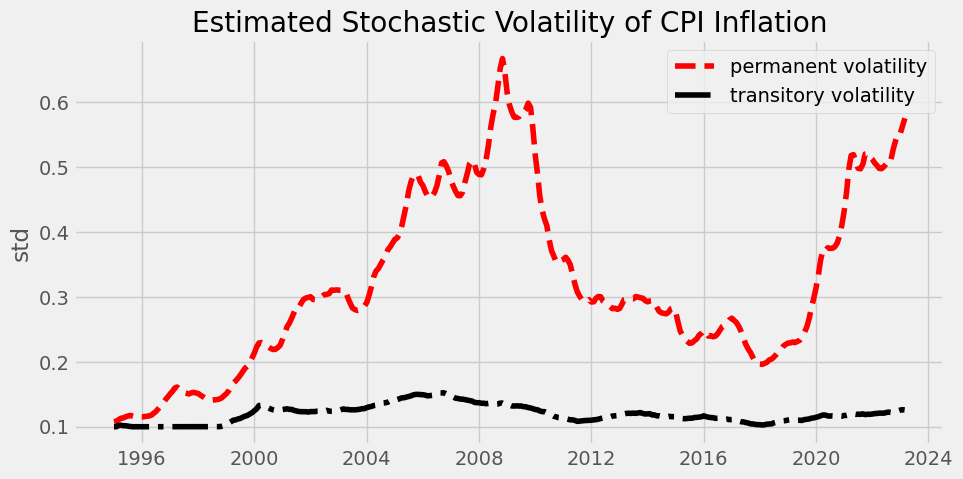

In [31]:
################
## quarterly ##
################

### quarterly data 
### exporting inflation series for process estimation using UCSV model in matlab

CPICQ.to_excel("../OtherData/CPICQ.xlsx")  ## this is for matlab estimation of UCSV model

################
## monthly ####
################

### process parameters estimation 

### exporting monthly inflation series for process estimation using UCSV model in matlab
CPIM.to_excel("../OtherData/CPIM.xlsx")  ## this is for matlab estimation of UCSV model

##########################################################################
##########################################################################
##########################################################################
## use matlab code stockwatson.m to estimate UCSV model before moving on!
##########################################################################
##########################################################################
##########################################################################
##########################################################################


## process parameters estimation for SV 

################
## quarterly ##
################

### import the estimated results 
CPICQ_UCSV_Est = pd.read_excel('../OtherData/UCSVestQ.xlsx')  
CPICQ_UCSV_Est.index = pd.to_datetime(CPICQ_UCSV_Est['date'],format='%Y%m%d')
CPICQ_UCSV_Est = CPICQ_UCSV_Est.drop(columns=['date'])
CPICQ_UCSV_Est = CPICQ_UCSV_Est.rename(columns = {'sd_eps':'sd_p_est',
                                      'sd_eta':'sd_t_est',
                                      'tau':'p'})  ## Loading ucsv model estimates 



################
## monthly ####
################

### import the estimated results 
CPIM_UCSV_Est = pd.read_excel('../OtherData/UCSVestM.xlsx')  
CPIM_UCSV_Est.index =pd.to_datetime(CPIM_UCSV_Est['date'],format='%Y%m%d')
CPIM_UCSV_Est = CPIM_UCSV_Est.drop(columns=['date'])
CPIM_UCSV_Est = CPIM_UCSV_Est.rename(columns = {'sd_eps':'sd_p_est',
                                                'sd_eta':'sd_t_est',
                                                'tau':'p'})  ## Loading ucsv model estimates 

########################################################################################
## be careful with the order, I define eta as the permanent and eps to be the transitory
 ######################################################################################
    

### quarterly plot 

plt.figure(figsize=(10,5))
plt.plot(CPICQ_UCSV_Est['sd_p_est'],
         'r--',
          lw = lw,
         label='permanent volatility')
plt.plot(CPICQ_UCSV_Est['sd_t_est'],
         'k-.',
         lw = lw,
         label='transitory volatility')
plt.title('Estimated Stochastic Volatility of Core CPI Inflation')
plt.ylabel('std')
plt.legend(loc=1)
plt.savefig('../graphs/inflation/UCSVQ.png')
    
### monthly plot 

plt.figure(figsize=(10,5))
plt.plot(CPIM_UCSV_Est['sd_p_est'],
         'r--',
          lw = lw,
         label='permanent volatility')
plt.plot(CPIM_UCSV_Est['sd_t_est'],
         'k-.',
         lw = lw,
         label='transitory volatility')
plt.title('Estimated Stochastic Volatility of CPI Inflation')
plt.ylabel('std')
plt.legend(loc=1)
plt.savefig('../graphs/inflation/UCSVM.png')

In [32]:
#########################################################
## specific to SV model  
######################################################

#############
## quarterly 
##############

n_burn_rt_historyQ = len(CPICQ_UCSV_Est) - len(historyQ)  

history_yQ = np.array(historyQ['RTCPICore'])
history_vol_pQ = np.array(CPICQ_UCSV_Est['sd_p_est'][n_burn_rt_historyQ:])**2  ## permanent
history_vol_tQ = np.array(CPICQ_UCSV_Est['sd_t_est'][n_burn_rt_historyQ:])**2 ## transitory

#history_volsQ = np.array([history_vol_pQ,
#                          history_vol_tQ])
history_pQ = np.array(CPICQ_UCSV_Est['p'][n_burn_rt_historyQ:])

## to burn 
n_burn_Q = len(history_pQ) - len(SPF_est['RTCPI'])
real_time_yQ = history_yQ[n_burn_Q:]
real_time_vol_pQ = history_vol_pQ[n_burn_Q:]
real_time_vol_tQ = history_vol_tQ[n_burn_Q:]
real_time_pQ = history_pQ[n_burn_Q:]

############
## monthly
############

n_burn_rt_historyM = len(CPIM_UCSV_Est) - len(historyM)  

history_yM = np.array(historyM['RTCPI'])
history_vol_pM = np.array(CPIM_UCSV_Est['sd_p_est'][n_burn_rt_historyM:])**2
history_vol_tM = np.array(CPIM_UCSV_Est['sd_t_est'][n_burn_rt_historyM:])**2

#history_volsM = np.array([history_vol_pM,
#                          history_vol_tM])  ## order is import 

history_pM = np.array(CPIM_UCSV_Est['p'][n_burn_rt_historyM:])

## to burn 
n_burn_M = len(history_pM) - len(SCE_est['RTCPI'])
real_time_yM = history_yM[n_burn_M:]
real_time_vol_pM = history_vol_pM[n_burn_M:]
real_time_vol_tM = history_vol_tM[n_burn_M:]
real_time_pM = history_pM[n_burn_M:]

In [33]:
## generate histories and real time array 

history_Q_sv = np.array([history_yQ,
                           history_pQ,
                           history_vol_pQ,
                           history_vol_tQ])
history_M_sv = np.array([history_yM,
                           history_pM,
                           history_vol_pM,
                           history_vol_tM])

real_time_Q_sv = np.array([real_time_yQ,
                         real_time_pQ,
                         real_time_vol_pQ,
                         real_time_vol_tQ])
real_time_M_sv = np.array([real_time_yM,
                         real_time_pM,
                         real_time_vol_pM,
                         real_time_vol_tM])

In [34]:
## process parameters 
process_paraQ_est_sv = np.array([0.05])
process_paraM_est_sv = np.array([0.05])

### Estimation 

In [35]:
agents_list = ['SPF',
               'SCE']

horizon_list = [4,
               12]

process_list = ['AR',
                'SV'
               ]

ex_model_list = ['SE',
                 'NI',
                 'DE',
                 'DENI'
                ]
nb_ex_model = len(ex_model_list)

moments_list = [['FE','FEVar','FEATV'],
               ['FE','FEVar','FEATV','Disg'],
               ['FE','FEVar','FEATV','Disg','Var']]

nb_moments = len(moments_list)

how_list =['2-step','Joint']

moments_list_general = ['FE','FE+Disg','FE+Disg+Var']

model_list = [sear0,
              niar0,
              dear0,
              deniar0,
              sesv0,
              nisv0,
              desv0,
              denisv0
]

algorithm_list = ['trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr',
                 'trust-constr'
                 ]


algorithm_joint_list = ['trust-constr',
                        'trust-constr',
                        'trust-constr',
                        'trust-constr',
                        None,
                        None,
                        None,
                        None
]

bns_list =[((0,1),),
           ((0,3),(0,3),),
           ((-2,2),(0,5),),
           ((-3,3),(0,3),),
           ((0,1),),
           ((0,3),(0,3),),
           ((-2,2),(0,np.inf),),
           ((-3,3),(0,3),)
]

bns_joint_list =[((0,1),(0.9,1),(0,np.inf),),
                 ((0,3),(0,3),(0.9,1),(0,np.inf),),
                 ((-2,2),(0,5),(0.9,1),(0,np.inf),),
                 ((-3,3),(0,3),(0.9,1),(0,np.inf),),
                 None,
                 None,
                 None,
                 None
]

data_mom_dict_list = [data_moms_dct_SPF,
                      data_moms_dct_SCE]

process_paras_list = [process_paraQ_est_ar,
                      process_paraQ_est_sv,
                      process_paraM_est_ar,
                      process_paraM_est_sv
]

realized_list = [realized_CPIC.astype(np.float64),
                 realized_CPI.astype(np.float64)]

real_time_list = [np.array(real_time_Q_ar),
                 np.array(real_time_Q_sv),  ## 4 x t array 
                np.array(real_time_M_ar),
                np.array(real_time_M_sv)
]  ## 4 x t array 

history_list = [np.array(history_Q_ar),
               np.array(history_Q_sv),     ## 4 x t array 
               np.array(history_M_ar), 
               np.array(history_M_sv)
]     ## 4 x t array 

## parameter guesses 
guesses_list = [np.array([0.2]),  ## se lbd 
               np.array([0.5,0.8]),  ## ni sigma_pb, sigma_pr
               np.array([0.3,0.4]),   ## de theta theta_sigma
               np.array([0.1,0.3])
               ]  ## deni theta, sigma_pb, sigma_pr

guesses_joint_list = [np.array([0.2,0.98,0.1]),            ## se lbd 
                     np.array([0.1,0.2,0.95,0.1]),      ## ni sigma_pb, sigma_pr
                     np.array([0.3,0.4,0.95,0.1]),      ## de theta theta_sigma
                     np.array([0.1,0.3,0.95,0.1]),  ## theta, sigma_pb, sigma_pr  
                       ## for sv models not used
                      np.array([0.3,0.2]),            ## se lbd 
                      np.array([0.1,0.2,0.2]),      ## ni sigma_pb, sigma_pr
                       np.array([0.3,0.2]),      ## de theta theta_sigma
                       np.array([0.1,0.2])
                     ]  ## deni theta, sigma_pb, sigma_pr]

n_exp_paras_list = [1,
                    2,
                    2,
                    2]


## names labels 

se_ar_names = [r'$\hat\lambda$',
                   r'$\rho$',
                   r'$\sigma_\omega$',
                   r'$\hat\lambda$', 
                   r'$\rho$',
                   r'$\sigma_\omega$']


ni_ar_names = [r'$\hat\sigma_{\epsilon}$',
                   r'$\hat\sigma_{\xi}$',
                   r'$\rho$',
                   r'$\sigma_\omega$',
                   r'$\hat\sigma_{\epsilon}$',
                   r'$\hat\sigma_{\xi}$',
                   r'NI: $\rho$',
                   r'NI: $\sigma_\omega$']


de_ar_names = [r'$\hat\theta$',
                   r'$\sigma_\theta$',
                   r'$\rho$',
                   r'$\sigma_\omega$',
                   r'$\hat\theta$',
                   r'$\sigma_\theta$',
                   r'$\rho$',
                   r'$\sigma_\omega$']


deni_ar_names = [r'$\hat\theta$',
                  # r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{\xi}$',
                   r'$\rho$',
                   r'$\sigma_\omega$',
                   r'$\hat\theta$',
                  # r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{\xi}$',
                   r'$\rho$',
                   r'$\sigma_\omega$']

se_sv_names = [r'$\hat\lambda$',
               r'$\gamma$']


ni_sv_names = [r'$\hat\sigma_{\epsilon}$',
               r'$\hat\sigma_{\xi}$',
               r'$\gamma$']


de_sv_names = [r'$\hat\theta$',
               r'$\sigma_\theta$',                   
               r'$\gamma$']


deni_sv_names = [r'$\hat\theta$',
                  # r'$\hat\sigma_{pb}$',
                   r'$\hat\sigma_{\xi}$',
                   r'$\gamma$']


names_list = [se_ar_names,
             ni_ar_names,
             de_ar_names,
             deni_ar_names,
             se_sv_names,
             ni_sv_names,
             de_sv_names,
             deni_sv_names]

In [36]:
################################################################################
## A loop to estimate the model for different agents, theory, inflation process and joint/2-step 
#################################################################################

paras_list = []
paras_step2_list = []
paras_joint_list = []
paras_joint_step2_list = []

for agent_id,agent in enumerate(agents_list):
    print(agent)
    realized_this = realized_list[agent_id]
    data_mom_dict_this = data_mom_dict_list[agent_id]
    for pg_id,process in enumerate(process_list):
        print(process)
        ## history and real-time inflation that is fed in the model depends on agent type and process
        agent_process_id = agent_id*2+pg_id       
        process_paras_this = process_paras_list[agent_process_id]
        real_time_this = real_time_list[agent_process_id]
        history_this = history_list[agent_process_id] 
        
        for exp_id,ex_model in enumerate(ex_model_list):
            print(ex_model)
            model_idx  = pg_id*nb_ex_model+exp_id
            print(model_idx)
            model_instance = model_list[model_idx]
            alg_this= algorithm_list[model_idx]
            bounds_this = bns_list[model_idx]
            print('2-step estimation uses algorithm'+alg_this)
            print('bounds for parameters'+str(bounds_this))
            alg_joint_this= algorithm_joint_list[model_idx]
            bounds_joint_this = bns_joint_list[model_idx]
            names_this = names_list[model_idx]

            ## feed inputs to the instance 
            instance = model_instance

            print(instance)
            print('horizon', horizon_list[agent_id])
            instance.horizon = horizon_list[agent_id]
            
            instance.GetRealization(realized_this)
            instance.real_time = real_time_this
            instance.history = history_this
            instance.process_para = process_paras_this 
            
            ## model-specific estimates holder 
            
            paras_list_this_model = []
            paras_step2_list_this_model = []
            paras_joint_list_this_model = []
            paras_joint_step2_list_this_model = []
            
            ## specific objetive function to minimize (only for expectation)

            for mom_id, moments_this in enumerate(moments_list):
                print(moments_this)
                print('Step 1')
                def Obj_this(paras_this):  
                    scalor = ObjGen(instance,
                                    paras = paras_this,
                                    data_mom_dict = data_mom_dict_this,
                                    moment_choice = List(moments_this),
                                    how ='expectation')
                    return scalor
                
                guess_this = guesses_list[exp_id]
                ## estimating
                para_est  = ParaEst(Obj_this,
                                 para_guess = guess_this,
                                 method= alg_this,
                                bounds = bounds_this)
                
                ## try it another time if no convergence 
                if np.isnan(para_est).any()==True:
                    para_est  = ParaEst(Obj_this,
                                 para_guess = guess_this,
                                 method= alg_this,
                                bounds = bounds_this)
                    
                ## same para est
                if np.isnan(para_est).any()==False:
                    
                    ## compute the efficient weighting matrix 
                    instance.exp_para = para_est
                    smm_dict_this = instance.SMM()
                    distance = np.array([smm_dict_this[mom] - data_mom_dict_this[mom] for mom in moments_this]) 
                    distance_diag = np.diag(distance*distance.T)
                    wm1st = np.linalg.inv(distance_diag)

                    ## 2-step estimation using efficient matrix 
                    def Obj_this_step2(paras_this):
                        scalor = ObjWeight(instance,
                                           paras = paras_this,
                                           weight = wm1st,
                                           data_mom_dict = data_mom_dict_this,
                                           moment_choice = List(moments_this),
                                           how ='expectation')
                        return scalor
                    para_est_step2  = ParaEst(Obj_this_step2,
                                        para_guess = guess_this,
                                        method= alg_this,
                                        bounds = bounds_this)
                    if np.isnan(para_est_step2).any()==True:
                        print('the 2-step estimation is nan')
                        para_est_step2_nan = np.array([np.nan])
                        para_est_step2 = para_est_step2_nan
                else:
                    print('the estimation is nan')
                    para_est_nan = np.array([np.nan])
                    para_est = para_est_nan
                                        
                    para_est_step2_nan = np.array([np.nan])
                    para_est_step2 = para_est_step2_nan
                    
                ## save para est
                
                para_est = np.round(para_est,2)
                print('Step 1:'+str(para_est))
                paras_list_this_model.append(para_est)
                paras_list.append(para_est)
                
                para_est_step2 = np.round(para_est_step2,2)
                print('Step 2:'+str(para_est_step2))
                paras_step2_list_this_model.append(para_est_step2)
                paras_step2_list.append(para_est_step2)
                
                
                ##  joint estimation 
                n_exp_paras_this = n_exp_paras_list[exp_id]
                
                moments_this_ = List(moments_this+['InfAV','InfVar','InfATV']) ## added inflation moments 
                
                if pg_id <=0: ## no joint estimation for SV models 
                    def Obj_joint_this(paras):
                        scalor = ObjGen(instance,
                                        paras = paras,
                                        data_mom_dict = data_mom_dict_this,
                                        moment_choice = moments_this_,
                                        how = 'joint',
                                        n_exp_paras = n_exp_paras_this)
                        return scalor

                    guess_this_ = guesses_joint_list[model_idx]
                    ## estimating
                    paras_joint_est = ParaEst(Obj_joint_this,
                                              para_guess = guess_this_,
                                              method= alg_joint_this,
                                              bounds = bounds_joint_this) ##Nelder-Mead  
                    if  np.isnan(paras_joint_est).any()==False:
                        ## compute the efficient weighting matrix 
                        instance.exp_para = paras_joint_est[0:n_exp_paras_this]     
                        instance.process_para = paras_joint_est[n_exp_paras_this:]
                        smm_dict_this = instance.SMM()
                        distance = np.array([smm_dict_this[mom] - data_mom_dict_this[mom] for mom in moments_this_]) 
                        distance_diag = np.diag(distance*distance.T)
                        wm1st = np.linalg.inv(distance_diag)

                        ## 2-step estimation using efficient matrix 
                        def Obj_joint_this_step2(paras_this):
                            scalor = ObjWeight(instance,
                                               paras = paras_this,
                                               weight = wm1st,
                                               data_mom_dict = data_mom_dict_this,
                                               moment_choice = moments_this_,
                                               how ='joint',
                                               n_exp_paras = n_exp_paras_this)
                            return scalor
                        ## re-estimating
                        para_est_joint_step2  = ParaEst(Obj_joint_this_step2,
                                                        para_guess = guess_this_,
                                                        method = alg_joint_this,
                                                        bounds = bounds_joint_this)     #  Nelder-Mead
                        if np.isnan(para_est_joint_step2).any()==True:
                            print('the 2-step estimation is nan')
                            para_est_joint_step2 = np.array([np.nan])
                        
                    else:
                        print('the estimation is nan')
                        paras_joint_est = np.array([np.nan])
                        para_est_joint_step2 = np.array([np.nan])
                
                else:
                    paras_joint_est = np.array([np.nan])
                    para_est_joint_step2 = np.array([np.nan])
                
                ## save in the list 
                paras_joint_est = np.round(paras_joint_est,2)
                print('Step 1:'+str(paras_joint_est))
                paras_joint_list_this_model.append(paras_joint_est)
                paras_joint_list.append(paras_joint_est)
                
                para_est_joint_step2 = np.round(para_est_joint_step2,2)
                print('Step 2:'+str(para_est_joint_step2))
                paras_joint_step2_list_this_model.append(para_est_joint_step2)
                paras_joint_step2_list.append(para_est_joint_step2)
            
            
            ### export model-specific estimates 
            names = names_list[model_idx]
            #print(paras_step2_list_this_model)
            #print(paras_joint_step2_list_this_model)
            para_est_tab_this_model = pd.DataFrame(paras_step2_list_this_model,
                                            index = moments_list_general)
            para_est_process_tab_this_model = pd.DataFrame([process_paras_this]*nb_moments,
                                            index = moments_list_general)
            para_joint_est_tab_this_model = pd.DataFrame(paras_joint_step2_list_this_model,
                                            index = moments_list_general)
            para_all_est_tab_this_model = pd.concat([para_est_tab_this_model,
                                                     para_est_process_tab_this_model,
                                                     para_joint_est_tab_this_model],
                                                    join = 'inner', axis=1)
            print(names_this)
            try:
                para_all_est_tab_this_model.columns = names_this 
            except:
                pass
            para_all_est_tab_this_model.to_excel('tables/after2022/'+agent+'_'+process+'_'+ex_model+'.xlsx',
                                       float_format='%.2f',
                                       index = True)

SPF
AR
SE
0
2-step estimation uses algorithmtrust-constr
bounds for parameters((0, 1),)
horizon 4
['FE', 'FEVar', 'FEATV']
Step 1


C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.063 s.


C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 56, function evaluations: 98, CG iterations: 46, optimality: 7.27e-09, constraint violation: 0.00e+00, execution time: 0.59 s.
Step 1:[0.36]
Step 2:[0.25]


C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 151, function evaluations: 376, CG iterations: 161, optimality: 2.33e+03, constraint violation: 0.00e+00, execution time:  2.1 s.
`xtol` termination condition is satisfied.
Number of iterations: 190, function evaluations: 1200, CG iterations: 271, optimality: 7.98e+03, constraint violation: 0.00e+00, execution time:  6.8 s.
Step 1:[0.21 0.99 0.16]
Step 2:[0.16 0.99 0.13]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.047 s.


C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 68, function evaluations: 122, CG iterations: 58, optimality: 7.27e-09, constraint violation: 0.00e+00, execution time: 0.75 s.
Step 1:[0.36]
Step 2:[0.25]
`xtol` termination condition is satisfied.
Number of iterations: 341, function evaluations: 1324, CG iterations: 697, optimality: 7.51e+03, constraint violation: 0.00e+00, execution time:  7.5 s.
`xtol` termination condition is satisfied.
Number of iterations: 76, function evaluations: 92, CG iterations: 105, optimality: 1.57e-07, constraint violation: 0.00e+00, execution time: 0.56 s.
Step 1:[0.25 0.99 0.13]
Step 2:[0.21 0.99 0.12]
['FE', 'FEVar', 'FEATV', 'Disg', 'Var']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.047 s.
`gtol` termination condition is satisfied.
Number of iterations: 78, function evaluations: 140, CG itera

B:\OneDrive - DAZ\GitHub\InfVar\workingfolder\python\SMMEst.py:222: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  model_mom_dict = model.SMM()


`gtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 36, CG iterations: 19, optimality: 2.51e-09, constraint violation: 0.00e+00, execution time:  1.9 s.
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 45, CG iterations: 25, optimality: 2.89e-09, constraint violation: 0.00e+00, execution time:  2.4 s.
Step 1:[3.   1.77]
Step 2:[3.   1.97]
`xtol` termination condition is satisfied.
Number of iterations: 109, function evaluations: 495, CG iterations: 239, optimality: 5.23e-07, constraint violation: 0.00e+00, execution time: 2.7e+01 s.
`xtol` termination condition is satisfied.
Number of iterations: 144, function evaluations: 860, CG iterations: 385, optimality: 2.17e-05, constraint violation: 0.00e+00, execution time: 4.8e+01 s.
Step 1:[1.34 2.67 0.98 0.21]
Step 2:[1.34 3.   0.98 0.21]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 30, function evalua

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 194, function evaluations: 1125, CG iterations: 456, optimality: 1.48e-07, constraint violation: 0.00e+00, execution time: 0.61 s.
`xtol` termination condition is satisfied.
Number of iterations: 173, function evaluations: 1160, CG iterations: 307, optimality: 4.01e-06, constraint violation: 0.00e+00, execution time: 0.53 s.
Step 1:[-1.74  2.88  1.    0.09]
Step 2:[2.   0.   0.92 0.47]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 114, CG iterations: 73, optimality: 1.47e-08, constraint violation: 0.00e+00, execution time: 0.13 s.


C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 133, function evaluations: 450, CG iterations: 221, optimality: 1.44e+04, constraint violation: 0.00e+00, execution time: 0.27 s.
Step 1:[-1.    0.86]
Step 2:[0.28 0.86]
`xtol` termination condition is satisfied.
Number of iterations: 241, function evaluations: 1495, CG iterations: 566, optimality: 1.16e-06, constraint violation: 0.00e+00, execution time: 0.77 s.
`xtol` termination condition is satisfied.
Number of iterations: 964, function evaluations: 5695, CG iterations: 3406, optimality: 6.09e+02, constraint violation: 0.00e+00, execution time:  3.5 s.
Step 1:[-1.76  0.7   1.    0.09]
Step 2:[1.98 0.86 0.92 0.47]
['FE', 'FEVar', 'FEATV', 'Disg', 'Var']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 51, CG iterations: 18, optimality: 8.46e-09, constraint violation: 0.00e+00, execution time: 0.078 s.
`xtol` termination condition is satisfied.
Number of iterations: 138, 

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 120, function evaluations: 348, CG iterations: 212, optimality: 7.70e-06, constraint violation: 0.00e+00, execution time:  1.1 s.
Step 1:[0.63 0.24]
Step 2:[0.49 0.3 ]
`xtol` termination condition is satisfied.
Number of iterations: 184, function evaluations: 1050, CG iterations: 430, optimality: 7.59e-07, constraint violation: 0.00e+00, execution time:  3.2 s.
`xtol` termination condition is satisfied.
Number of iterations: 376, function evaluations: 2320, CG iterations: 1027, optimality: 4.82e-02, constraint violation: 0.00e+00, execution time:  7.2 s.
Step 1:[-0.83  1.39  1.    0.1 ]
Step 2:[1.06 0.02 0.95 0.36]
['FE', 'FEVar', 'FEATV', 'Disg', 'Var']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 26, function evaluations: 51, CG iterations: 29, optimality: 6.06e-09, constraint violation: 0.00e+00, execution time: 0.19 s.
`xtol` termination condition is satisfied.
Number of iterations: 107, fun

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 82, CG iterations: 39, optimality: 7.13e-09, constraint violation: 0.00e+00, execution time: 0.97 s.


C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 114, CG iterations: 57, optimality: 6.87e-09, constraint violation: 0.00e+00, execution time:  1.3 s.
Step 1:[0.28]
Step 2:[0.3]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.078 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.078 s.
Step 1:[0.36]
Step 2:[0.36]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'Var']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.078 s.
`gtol` termination condition is satisfie

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 42, function evaluations: 68, CG iterations: 32, optimality: 7.13e-09, constraint violation: 0.00e+00, execution time:  3.8 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.23 s.
Step 1:[0.28]
Step 2:[0.36]
`xtol` termination condition is satisfied.
Number of iterations: 325, function evaluations: 1700, CG iterations: 472, optimality: 2.66e-06, constraint violation: 0.00e+00, execution time: 1.2e+02 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 6000, CG iterations: 4495, optimality: 6.52e+02, constraint violation: 0.00e+00, execution time: 3.1e+02 s.
the 2-step estimation is nan
Step 1:[0.03 1.   0.01]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 54, fu

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 7525, CG iterations: 2910, optimality: 1.07e-02, constraint violation: 0.00e+00, execution time: 1.7e+03 s.
the estimation is nan
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 19, function evaluations: 39, CG iterations: 16, optimality: 2.02e-09, constraint violation: 0.00e+00, execution time:  8.0 s.
`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 39, CG iterations: 13, optimality: 4.57e-09, constraint violation: 0.00e+00, execution time:  8.0 s.
Step 1:[3. 3.]
Step 2:[3. 3.]
`xtol` termination condition is satisfied.
Number of iterations: 299, function evaluations: 2080, CG iterations: 499, optimality: 1.20e-04, constraint violation: 0.00e+00, execution time: 4.7e+02 s.
`xtol` termination condition is satisfied.
Number of iterations: 290, function evalua

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 123, CG iterations: 78, optimality: 2.38e-08, constraint violation: 0.00e+00, execution time: 0.31 s.
`xtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 204, CG iterations: 63, optimality: 1.33e-07, constraint violation: 0.00e+00, execution time: 0.46 s.
Step 1:[-1.19  1.72]
Step 2:[0.43 0.87]
`gtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 255, CG iterations: 117, optimality: 4.44e-09, constraint violation: 0.00e+00, execution time: 0.61 s.
`xtol` termination condition is satisfied.
Number of iterations: 95, function evaluations: 550, CG iterations: 294, optimality: 3.05e-08, constraint violation: 0.00e+00, execution time:  1.2 s.
Step 1:[-2.    5.    0.94  0.7 ]
Step 2:[-0.93  1.65  0.98  0.4 ]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 24, function ev

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 96, function evaluations: 198, CG iterations: 153, optimality: 6.08e-07, constraint violation: 0.00e+00, execution time:  3.7 s.
Step 1:[-0.36  0.42]
Step 2:[0.2  1.33]
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 55, CG iterations: 5988, optimality: 7.09e-01, constraint violation: 0.00e+00, execution time:  2.4 s.
the estimation is nan
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 18, CG iterations: 2994, optimality: 4.75e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 18, CG iterations: 2994, optimality: 4.75e-01, constraint violation: 0.00e+00, execution time:  1.3 s.
the estimation is nan
Step 1:[nan]
Step 2:[nan]
The

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.43 s.
`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 6, CG iterations: 2, optimality: 5.54e-09, constraint violation: 0.00e+00, execution time: 0.43 s.
Step 1:[0.36]
Step 2:[0.36]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 47, function evaluations: 76, CG iterations: 37, optimality: 7.17e-09, constraint violation: 0.00e+00, execution time:  7.4 s.
`gtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 60, CG iterations: 29, optimality: 7.21e-09, constraint violation: 0.00e+00, execution time:  5.8 s.
Step 1:[0.27]
Step 2:[0.27]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'Var']
Step 1
`gtol` termination condition is satisfied

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 56, function evaluations: 144, CG iterations: 45, optimality: 5.22e-09, constraint violation: 0.00e+00, execution time: 5e+01 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 4494, CG iterations: 1496, optimality: 1.35e-02, constraint violation: 0.00e+00, execution time: 1.6e+03 s.
the 2-step estimation is nan
Step 1:[0.65 0.03]
Step 2:[nan]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`gtol` termination condition is satisfied.
Number of iterations: 700, function evaluations: 2088, CG iterations: 689, optimality: 5.39e-09, constraint violation: 0.00e+00, execution time: 7.4e+02 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 4491, CG iterations: 1496, optimality: 1.24e-02, constraint violation: 0.00e+00, execution time: 1.6e+03 s.
the 2-step estimation is nan
Step 1:[0.66 0.03]
Step

C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 129, CG iterations: 60, optimality: 3.93e-08, constraint violation: 0.00e+00, execution time:  5.3 s.
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 210, CG iterations: 71, optimality: 1.99e-07, constraint violation: 0.00e+00, execution time:  8.7 s.
Step 1:[-0.24  0.77]
Step 2:[-0.07  0.57]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`xtol` termination condition is satisfied.
Number of iterations: 60, function evaluations: 150, CG iterations: 66, optimality: 7.85e-08, constraint violation: 0.00e+00, execution time:  6.2 s.
`xtol` termination condition is satisfied.
Number of iterations: 128, function evaluations: 105, CG iterations: 231, optimality: 4.08e+01, constraint violation: 0.00e+00, execution time:  4.4 s.
Step 1:[-0.24  1.07]
Step 2:[0.47 1.07]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg', 'Var']
Step 1
`xtol

C:\Anaconda3\Lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:53: RuntimeWarning: invalid value encountered in scalar divide
  orth = norm_A_g / (norm_A*norm_g)
C:\Anaconda3\Lib\site-packages\scipy\optimize\_trustregion_constr\qp_subproblem.py:573: RuntimeWarning: invalid value encountered in scalar divide
  alpha = rt_g / pt_H_p
C:\Anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 115, function evaluations: 78, CG iterations: 204, optimality: 5.10e-01, constraint violation: 0.00e+00, execution time: 5.2e+01 s.
The maximum number of function evaluations is exceeded.
Number of iterations: 1500, function evaluations: 4500, CG iterations: 1528, optimality: 4.20e-02, constraint violation: 0.00e+00, execution time: 3.1e+03 s.
the 2-step estimation is nan
Step 1:[-0.51  0.41]
Step 2:[nan]
Step 1:[nan]
Step 2:[nan]
['FE', 'FEVar', 'FEATV', 'Disg']
Step 1
`xtol` termination condition is satisfied.
Number of iterations: 114, function evaluations: 75, CG iterations: 201, optimality: 5.97e-01, constraint violation: 0.00e+00, execution time: 5e+01 s.
`xtol` termination condition is satisfied.
Number of iterations: 123, function evaluations: 15, CG iterations: 219, optimality: 1.40e-01, constraint violation: 0.00e+00, execution time:  8.4 s.
Step 1:[-0.56  0.44]
Step 2:[0.43 0.26]
Step 1:[nan]
Step 2:[nan]
['FE'

In [37]:
## create multiple index to store coefficient estimates 

iterables = [agents_list, process_list, ex_model_list,moments_list_general]
midx = pd.MultiIndex.from_product(iterables, names=['Agents', 'Process','Model','Moments'])
paras_table = pd.DataFrame(index = midx)

## 2-step table
paras_list = [tuple(paras) for paras in paras_list]
paras_table['ParaEst'] = paras_list

paras_step2_list = [tuple(paras) for paras in paras_step2_list]
paras_table['ParaEst2step'] = paras_step2_list

## joint table
paras_joint_table = pd.DataFrame(index = midx)

paras_joint_list = [tuple(paras) for paras in paras_joint_list]
paras_joint_table['ParaEst'] = paras_joint_list

paras_joint_step2_list = [tuple(paras) for paras in paras_joint_step2_list]
paras_joint_table['ParaEst2step'] = paras_joint_step2_list


In [38]:
paras_table.columns = [['2-step Estimate',
                        '2-step Estimate 2nd step']]
paras_joint_table.columns = [['Joint Estimate',
                              'Joint Estimate 2nd step']]

In [39]:
paras_combine_table = pd.merge(paras_table,
                               paras_joint_table,
                               how='outer',
                               left_index=True,
                               right_index=True)

In [40]:
print(process_paraQ_est_ar)
print(process_paraM_est_ar)

[0.99907885 0.44902037]
[0.99212956 0.46016016]


In [41]:
paras_combine_table

2-step Estimate 2-step Estimate 2nd step  \
Agents Process Model Moments                                                
SPF    AR      SE    FE                  (0.36,)                  (0.25,)   
                     FE+Disg             (0.36,)                  (0.25,)   
                     FE+Disg+Var         (0.36,)                  (0.25,)   
               NI    FE              (3.0, 1.77)              (3.0, 1.97)   
                     FE+Disg        (1.59, 1.64)               (1.5, 3.0)   
                     FE+Disg+Var    (1.52, 1.36)             (1.33, 2.18)   
               DE    FE             (-1.75, 2.3)            (-1.78, 0.12)   
                     FE+Disg        (-1.0, 0.86)             (0.28, 0.86)   
                     FE+Disg+Var   (-0.99, 0.86)             (0.26, 0.86)   
               DENI  FE             (0.39, 0.42)                   (nan,)   
                     FE+Disg        (0.63, 0.24)              (0.49, 0.3)   
                     FE+Disg+Var    (0.64, 0.24)             (0.52, 0.29)   
       SV      SE    FE                  (0.28,)                   (0.3,)   
                     FE+Disg             (0.36,)                  (0.36,)   
                     FE+Disg+Var         (0.36,)                   (0.3,)   
               NI    FE              (2.16, 3.0)               (2.3, 3.0)   
                     FE+Disg         (2.16, 3.0)              (2.31, 3.0)   
                     FE+Disg+Var     (2.16, 3.0)              (2.38, 3.0)   
               DE    FE             (0.32, 0.48)             (0.31, 0.41)   
                     FE+Disg        (0.32, 0.19)             (0.28, 0.19)   
                     FE+Disg+Var    (0.32, 0.19)             (0.31, 0.19)   
               DENI  FE             (-0.55, 0.8)            (-0.27, 0.92)   
                     FE+Disg        (-0.53, 0.8)            (-0.28, 0.92)   
                     FE+Disg+Var    (-0.53, 0.8)            (-0.28, 0.91)   
SCE    AR      SE    FE                  (0.28,)                  (0.36,)   
                     FE+Disg             (0.26,)                  (0.36,)   
                     FE+Disg+Var         (0.26,)                  (0.36,)   
               NI    FE               (3.0, 3.0)              (0.12, 3.0)   
                     FE+Disg          (3.0, 3.0)               (3.0, 3.0)   
                     FE+Disg+Var      (3.0, 3.0)               (3.0, 3.0)   
               DE    FE            (-1.19, 1.72)             (0.43, 0.87)   
                     FE+Disg        (-1.96, 5.0)             (-0.81, 5.0)   
                     FE+Disg+Var   (-1.34, 4.85)             (0.27, 4.85)   
               DENI  FE            (-0.36, 0.42)              (0.2, 1.33)   
                     FE+Disg              (nan,)                   (nan,)   
                     FE+Disg+Var          (nan,)                   (nan,)   
       SV      SE    FE                  (0.36,)                  (0.36,)   
                     FE+Disg             (0.27,)                  (0.27,)   
                     FE+Disg+Var         (0.28,)                  (0.26,)   
               NI    FE             (0.65, 0.03)                   (nan,)   
                     FE+Disg        (0.66, 0.03)                   (nan,)   
                     FE+Disg+Var    (0.66, 0.03)                   (nan,)   
               DE    FE            (-0.24, 0.77)            (-0.07, 0.57)   
                     FE+Disg       (-0.24, 1.07)             (0.47, 1.07)   
                     FE+Disg+Var   (-0.24, 1.07)            (-0.06, 1.07)   
               DENI  FE            (-0.51, 0.41)                   (nan,)   
                     FE+Disg       (-0.56, 0.44)             (0.43, 0.26)   
                     FE+Disg+Var   (-0.56, 0.44)             (0.43, 0.26)   

                                             Joint Estimate  \
Agents Process Model Moments                                  
SPF    AR      SE    FE                  (0.21, 0.99, 0.

In [42]:
## only 2nd-step estimates 

paras_combine_table_2step = paras_combine_table[['2-step Estimate 2nd step','Joint Estimate 2nd step']]

paras_combine_table_2step

2-step Estimate 2nd step  \
Agents Process Model Moments                                
SPF    AR      SE    FE                           (0.25,)   
                     FE+Disg                      (0.25,)   
                     FE+Disg+Var                  (0.25,)   
               NI    FE                       (3.0, 1.97)   
                     FE+Disg                   (1.5, 3.0)   
                     FE+Disg+Var             (1.33, 2.18)   
               DE    FE                     (-1.78, 0.12)   
                     FE+Disg                 (0.28, 0.86)   
                     FE+Disg+Var             (0.26, 0.86)   
               DENI  FE                            (nan,)   
                     FE+Disg                  (0.49, 0.3)   
                     FE+Disg+Var             (0.52, 0.29)   
       SV      SE    FE                            (0.3,)   
                     FE+Disg                      (0.36,)   
                     FE+Disg+Var                   (0.3,)   
               NI    FE                        (2.3, 3.0)   
                     FE+Disg                  (2.31, 3.0)   
                     FE+Disg+Var              (2.38, 3.0)   
               DE    FE                      (0.31, 0.41)   
                     FE+Disg                 (0.28, 0.19)   
                     FE+Disg+Var             (0.31, 0.19)   
               DENI  FE                     (-0.27, 0.92)   
                     FE+Disg                (-0.28, 0.92)   
                     FE+Disg+Var            (-0.28, 0.91)   
SCE    AR      SE    FE                           (0.36,)   
                     FE+Disg                      (0.36,)   
                     FE+Disg+Var                  (0.36,)   
               NI    FE                       (0.12, 3.0)   
                     FE+Disg                   (3.0, 3.0)   
                     FE+Disg+Var               (3.0, 3.0)   
               DE    FE                      (0.43, 0.87)   
                     FE+Disg                 (-0.81, 5.0)   
                     FE+Disg+Var             (0.27, 4.85)   
               DENI  FE                       (0.2, 1.33)   
                     FE+Disg                       (nan,)   
                     FE+Disg+Var                   (nan,)   
       SV      SE    FE                           (0.36,)   
                     FE+Disg                      (0.27,)   
                     FE+Disg+Var                  (0.26,)   
               NI    FE                            (nan,)   
                     FE+Disg                       (nan,)   
                     FE+Disg+Var                   (nan,)   
               DE    FE                     (-0.07, 0.57)   
                     FE+Disg                 (0.47, 1.07)   
                     FE+Disg+Var            (-0.06, 1.07)   
               DENI  FE                            (nan,)   
                     FE+Disg                 (0.43, 0.26)   
                     FE+Disg+Var             (0.43, 0.26)   

                                    Joint Estimate 2nd step  
Agents Process Model Moments                                 
SPF    AR      SE    FE                  (0.16, 0.99, 0.13)  
                     FE+Disg             (0.21, 0.99, 0.12)  
                     FE+Disg+Var                     (nan,)  
               NI    FE             (1.34, 3.0, 0.98, 0.21)  
                     FE+Disg        (1.48, 3.0, 0.98, 0.21)  
                     FE+Disg+Var   (1.58, 1.31, 0.99, 0.16)  
               DE    FE              (2.0, 0.0, 0.92, 0.47)  
                     FE+Disg       (1.98, 0.86, 0.92, 0.47)  
                     FE+Disg+Var   (0.31, 0.73, 0.98, 0.26)  
               DENI  FE                              (nan,)  
                     FE+Disg       (1.06, 0.02, 0.95, 0.36)  
                     FE+Disg+Var    (0.6, 0.23, 0.98, 0.23)  
       SV      SE    FE                              (nan,)  
                     FE+Disg                        

In [43]:
## Flag those under-identified cases 

ui_list = [('SPF','AR','NI','FE'),
          ('SCE','AR','NI','FE'),
          ('SPF','AR','DENI','FE'),
          ('SCE','AR','DENI','FE'),
          ('SPF','SV','NI','FE'),
          ('SCE','SV','NI','FE'),
          ('SPF','SV','DENI','FE'),
          ('SCE','SV','DENI','FE')
          ]


for case in ui_list:
    print(case)
    for name in paras_combine_table.columns:
        print(name)
        paras_combine_table.loc[case,name]= tuple(np.array([]))
        #paras_combine_table.loc[case][name] = tuple(np.array([]))

('SPF', 'AR', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'AR', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SPF', 'AR', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'AR', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SPF', 'SV', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'SV', 'NI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SPF', 'SV', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estimate 2nd step',)
('SCE', 'SV', 'DENI', 'FE')
('2-step Estimate',)
('2-step Estimate 2nd step',)
('Joint Estimate',)
('Joint Estim

C:\Users\TaoWang\AppData\Local\Temp\ipykernel_2008\2813330448.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  paras_combine_table.loc[case,name]= tuple(np.array([]))


In [44]:
t_sim = 500
t_burn = 30

def simulate_history(pg_para,
                     t_sim,
                     t_burn):
    if len(pg_para)==2:
        ρ,σ = pg_para
        history_this = SimAR1(ρ,
                              σ,
                              t_sim)
        real_time_this = history_this[t_burn:-2] 
        realized_this = history_this[t_burn+1:-1]
        
    elif len(pg_para)==1:
        γ_fake = pg_para[0]
        
        
        history_this,p_history_this,vol_p_history_this,vol_t_history_this = SimUCSV(γ_fake,
                                                                                    nobs = t_sim,
                                                                                    p0 = p0_fake) 
        history_this =  np.array([history_this,
                                p_history_this,
                                vol_p_history_this,
                                vol_t_history_this]
                               )

        real_time_this = history_this[:,t_burn:-2]
        realized_this = history_this[0,t_burn+1:-1] ## notice, just Y itself is 
        
    return realized_this,history_this,real_time_this

In [45]:
## generate model moments

smm_list = []
smm_joint_list = []
smm_ts_list = []

for agent_id,agent in enumerate(agents_list):
    print(agent)
    realized_this = realized_list[agent_id]
    data_mom_dict_this = data_mom_dict_list[agent_id]

    for pg_id,process in enumerate(process_list):
        print(process)
        process_paras_this = process_paras_list[agent_process_id]
        
        ## history and real-time inflation that is fed in the model depends on agent type and process
        agent_process_id = agent_id*2+pg_id       
        
        process_paras_this = process_paras_list[agent_process_id]
        real_time_this = real_time_list[agent_process_id]
        history_this = history_list[agent_process_id]
        
        for exp_id,ex_model in enumerate(ex_model_list):
            n_exp_model = len(ex_model_list)
            print(ex_model)
            model_idx  = pg_id*n_exp_model+exp_id
            #print(model_idx)
            instance = model_list[model_idx]
            print(instance)
            
            ## directly use the history 
            instance.GetRealization(realized_this)   
            instance.history = history_this
            instance.real_time = real_time_this
            print("Length of real time series is "+str(len(instance.real_time)))
            
            ## compute moments with these parameters 
            for moments in moments_list_general:
                ## 2-step moments 
                para_est_this = np.array(list(paras_combine_table.loc[agent,process,ex_model,moments]['2-step Estimate 2nd step'])).flatten()
                print(para_est_this)
                print(process_paras_this)
                
                try:
                    instance.process_para = process_paras_this
                    instance.exp_para = para_est_this
                    smm_ts_this = instance.SimForecasts()
                    print('Length of simulated moments is '+str(len(smm_ts_this['FE'])))
                    smm_this = instance.SMM()
                    print(smm_this)

                except:
                    print('failed')
                    smm_this = {}
                    smm_ts_this = {"Forecast":np.nan,
                                  "FE":np.nan,
                                  'Disg':np.nan,
                                  'Var':np.nan}
                smm_list.append(smm_this)
                smm_ts_list.append(smm_ts_this)

                ## joint moments
                n_exp_paras_this = n_exp_paras_list[exp_id]
                para_est_this_ = np.array(list(paras_combine_table.loc[agent,process,ex_model,moments]['Joint Estimate 2nd step'])).flatten()
                print(para_est_this_)
                try:
                    instance.exp_para = para_est_this_[0:n_exp_paras_this]     
                    instance.process_para = para_est_this_[n_exp_paras_this:]
                    
                    try:
                        smm_this = instance.SMM()
                        print(smm_this)
                        smm_joint_list.append(smm_this)
                    except:
                        smm_this = {}
                        smm_joint_list.append(smm_this)
                except:
                    smm_this = {}
                    smm_joint_list.append(smm_this)

SPF
AR
SE
Length of real time series is 15
[0.25]
[0.99907885 0.44902037]
Length of simulated moments is 15
{InfAV: 0.0, InfVar: 109.48953643852946, InfATV: 108.2853761127015, Forecast: 2.097786905228389, FE: -0.24810544465055784, FEVar: 1.1846829174929474, FEATV: -0.5514987671328793, Disg: 0.26051963664039657, DisgVar: 0.21340886069124235, DisgATV: 0.005170835648887238, Var: 2.9914096185523227, VarVar: 0.0004890823173281792, VarATV: 0.00015677137619144103}
[0.16 0.99 0.13]
{InfAV: 0.0, InfVar: 0.8492462311557778, InfATV: 0.7527590116584202, Forecast: 1.7656924458139867, FE: -0.5801999040649604, FEVar: 1.392118298471442, FEATV: -0.6201949009248384, Disg: 0.19702668340860333, DisgVar: 0.11560808217075841, DisgATV: 0.004999807137479495, Var: 0.24387663427341072, VarVar: 2.0466779016100327e-06, VarATV: 6.068025329746977e-07}
[0.25]
[0.99907885 0.44902037]
Length of simulated moments is 15
{InfAV: 0.0, InfVar: 109.48953643852946, InfATV: 108.2853761127015, Forecast: 2.097786905228389, FE: 

failed
[]
[2.31 3.  ]
[0.05]
Length of simulated moments is 15
{InfAV: nan, InfVar: nan, InfATV: nan, Forecast: 2.359940422808719, FE: 0.014048072929771867, FEVar: 0.6741165653818407, FEATV: -0.5682712995288539, Disg: 3.837402560221945e-07, DisgVar: 7.208244214395523e-14, DisgATV: -9.514495567016065e-16, Var: 0.6103734784372041, VarVar: 0.14049502338628825, VarATV: -0.0013075444784129834}
[nan]
[2.38 3.  ]
[0.05]
Length of simulated moments is 15
{InfAV: nan, InfVar: nan, InfATV: nan, Forecast: 2.359940422808719, FE: 0.014048072929771867, FEVar: 0.6741165653818407, FEATV: -0.5682712995288539, Disg: 3.837402560221945e-07, DisgVar: 7.208244214395523e-14, DisgATV: -9.514495567016065e-16, Var: 0.6103734784372041, VarVar: 0.14049502338628825, VarATV: -0.0013075444784129834}
[nan]
DE
Length of real time series is 4
[0.31 0.41]
[0.05]
Length of simulated moments is 15
{InfAV: nan, InfVar: nan, InfATV: nan, Forecast: 1.996166348324266, FE: -0.3497260015546811, FEVar: 1.4018774320140153, FEATV:

Length of simulated moments is 109
{InfAV: 0.0, InfVar: nan, InfATV: nan, Forecast: 2.5615757465178195, FE: -0.19796019149651575, FEVar: 1.604069484529617, FEATV: -0.4371074440921947, Disg: 0.49214976018850287, DisgVar: 0.535140573693709, DisgATV: 0.1840037129041201, Var: 0.23396321958923144, VarVar: 0.09645712333102976, VarATV: 0.06502739646977718}
[nan]
{InfAV: 0.0, InfVar: nan, InfATV: nan, Forecast: 2.678297686351491, FE: -0.08123825166284696, FEVar: 5.761658652628146, FEATV: 2.63205343900702, Disg: 6.184669496932733e-28, DisgVar: 0.0, DisgATV: 0.0, Var: nan, VarVar: nan, VarATV: nan}
[0.26]
[0.05]
Length of simulated moments is 109
{InfAV: 0.0, InfVar: nan, InfATV: nan, Forecast: 2.5540725780397087, FE: -0.2054633599746271, FEVar: 1.6313344764044309, FEATV: -0.4362601827142874, Disg: 0.5160092833282118, DisgVar: 0.5744211118456058, DisgATV: 0.20754828939534037, Var: 0.2343306452389694, VarVar: 0.09675209182569006, VarATV: 0.06499265212103572}
[nan]
{InfAV: 0.0, InfVar: nan, InfATV

In [46]:
## model moments 
smm_model = pd.DataFrame(smm_list,
                         columns = list(smm_list[0].keys()),
                         index = midx)

smm_joint_model = pd.DataFrame(smm_joint_list,
                               columns = list(smm_joint_list[1].keys()),
                               index = midx)

In [47]:
## store times series of moments 

smm_names = ['Forecast','FE','Disg','Var']

iterables = [agents_list, process_list, ex_model_list,moments_list_general,smm_names]

midx_ts = pd.MultiIndex.from_product(iterables, names=['Agents', 'Process','Model','Moments','Variable'])

smm_ts_table = pd.DataFrame(index = midx_ts)

smm_ts_list_new = [ts[name] for ts in smm_ts_list for name in smm_names]

smm_ts_table['smm_ts'] = smm_ts_list_new

In [48]:
exp_data_SPF['Var'].index

DatetimeIndex(['2007-10-01', '2008-10-01', '2009-10-01', '2010-10-01',
               '2011-10-01', '2012-10-01', '2013-10-01', '2014-10-01',
               '2015-10-01', '2016-10-01', '2017-10-01', '2018-10-01',
               '2019-10-01', '2020-10-01', '2021-10-01'],
              dtype='datetime64[ns]', freq='AS-OCT')

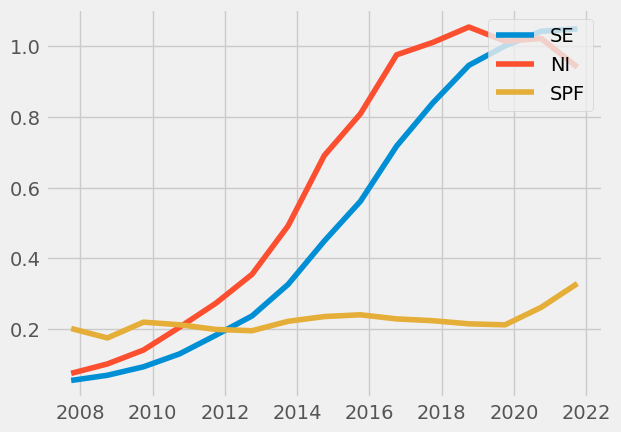

In [49]:
plt.plot(exp_data_SPF['Var'].index,smm_ts_table.loc['SPF','SV','SE','FE+Disg+Var',:].loc['Var','smm_ts'],label='SE')
plt.plot(exp_data_SPF['Var'].index,smm_ts_table.loc['SPF','SV','NI','FE+Disg+Var',:].loc['Var','smm_ts'],label='NI')
plt.plot(exp_data_SPF['Var'].index,np.array(exp_data_SPF['Var']),label='SPF')
#plt.plot(smm_ts_table.loc['SPF','SV','DE','FE+Disg+Var',:].loc['Var','smm_ts'],label='DE')
#plt.plot(smm_ts_table.loc['SPF','SV','DENI','FE+Disg+Var',:].loc['Var','smm_ts'],label='DENI')

plt.legend(loc=1)

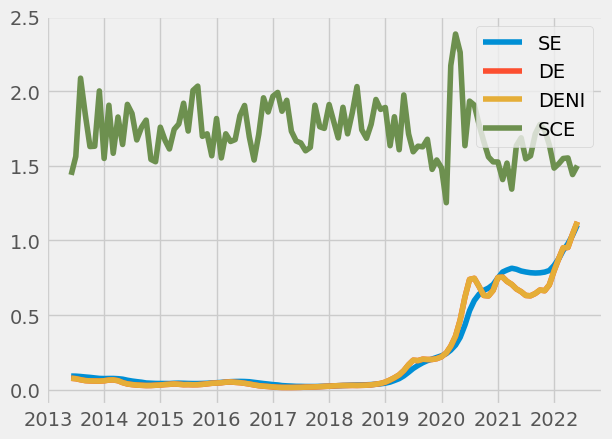

In [50]:
plt.plot(exp_data_SCE['Var'].index,smm_ts_table.loc['SCE','SV','SE','FE+Disg+Var',:].loc['Var','smm_ts'],label='SE')
plt.plot(exp_data_SCE['Var'].index,smm_ts_table.loc['SCE','SV','DE','FE+Disg+Var',:].loc['Var','smm_ts'],label='DE')
plt.plot(exp_data_SCE['Var'].index,smm_ts_table.loc['SCE','SV','DENI','FE+Disg+Var',:].loc['Var','smm_ts'],label='DENI')

plt.plot(exp_data_SCE['Var'].index,np.array(exp_data_SCE['Var']),label='SCE')
plt.legend(loc=1)

In [51]:
## data moments

smm_data_spf =  pd.DataFrame(data_moms_dct_SPF.values()).T
smm_data_spf.columns = data_moms_dct_SPF.keys()

smm_data_sce =  pd.DataFrame(data_moms_dct_SCE.values()).T
smm_data_sce.columns = data_moms_dct_SCE.keys()

In [52]:
mom_compare_spf = smm_data_spf.append(smm_model.loc['SPF'])
mom_compare_sce = smm_data_sce.append(smm_model.loc['SCE'])

mom_joint_compare_spf = smm_data_spf.append(smm_joint_model.loc['SPF','AR'])
mom_joint_compare_sce = smm_data_sce.append(smm_joint_model.loc['SCE','AR'])

C:\Users\TaoWang\AppData\Local\Temp\ipykernel_2008\835143023.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mom_compare_spf = smm_data_spf.append(smm_model.loc['SPF'])
C:\Users\TaoWang\AppData\Local\Temp\ipykernel_2008\835143023.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mom_compare_sce = smm_data_sce.append(smm_model.loc['SCE'])
C:\Users\TaoWang\AppData\Local\Temp\ipykernel_2008\835143023.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  mom_joint_compare_spf = smm_data_spf.append(smm_joint_model.loc['SPF','AR'])
C:\Users\TaoWang\AppData\Local\Temp\ipykernel_2008\835143023.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mom_joint_compare_spf = smm_data_spf.append(smm_joint_mo

In [53]:
## export 
mom_compare_spf.to_excel('./tables/after2022/spf_moments.xlsx')
mom_compare_sce.to_excel('./tables/after2022/sce_moments.xlsx')
mom_joint_compare_spf.to_excel('./tables/after2022/spf_joint_est_moments.xlsx')
mom_joint_compare_sce.to_excel('./tables/after2022/sce_joint_est_moments.xlsx')

In [54]:
mom_compare_spf

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,-0.00,1.29,1.18,-0.32,1.41,0.58,0.18,0.02,0.01,0.22,0.00,0.00,NaN
"(AR, SE, FE)",0.00,109.49,108.29,-0.25,1.18,-0.55,0.26,0.21,0.01,2.99,0.00,0.00,2.10
"(AR, SE, FE+Disg)",0.00,109.49,108.29,-0.25,1.18,-0.55,0.26,0.21,0.01,2.99,0.00,0.00,2.10
"(AR, SE, FE+Disg+Var)",0.00,109.49,108.29,-0.25,1.18,-0.55,0.26,0.21,0.01,2.99,0.00,0.00,2.10
"(AR, NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(AR, NI, FE+Disg)",0.00,109.49,108.29,0.13,1.15,-0.71,0.06,0.00,-0.00,2.89,0.00,0.00,2.48
"(AR, NI, FE+Disg+Var)",0.00,109.49,108.29,0.08,1.07,-0.67,0.07,0.00,-0.00,2.80,0.00,0.00,2.43
"(AR, DE, FE)",0.00,109.49,108.29,-0.34,1.41,0.36,0.01,0.00,0.00,2.40,0.00,0.00,2.01
"(AR, DE, FE+Disg)",0.00,109.49,108.29,0.04,0.75,-0.61,0.27,0.34,0.02,2.40,0.00,0.00,2.39
"(AR, DE, FE+Disg+Var)",0.00,109.49,108.29,0.04,0.74,-0.61,0.27,0.34,0.02,2.40,0.00,0.00,2.39


In [55]:
mom_joint_compare_spf

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,-0.00,1.29,1.18,-0.32,1.41,0.58,0.18,0.02,0.01,0.22,0.00,0.00,NaN
"(SE, FE)",0.00,0.85,0.75,-0.58,1.39,-0.62,0.20,0.12,0.00,0.24,0.00,0.00,1.77
"(SE, FE+Disg)",0.00,0.72,0.64,-0.53,1.29,-0.58,0.21,0.15,0.01,0.19,0.00,0.00,1.81
"(SE, FE+Disg+Var)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(NI, FE+Disg)",0.00,1.11,0.87,-0.69,1.46,-0.77,0.01,0.00,0.00,0.57,0.00,0.00,1.66
"(NI, FE+Disg+Var)",0.00,1.29,1.14,-0.48,1.43,-0.72,0.03,0.00,0.00,0.39,0.00,0.00,1.87
"(DE, FE)",0.00,1.44,0.53,-1.21,1.12,-0.66,0.00,0.00,0.00,1.24,0.00,0.00,1.14
"(DE, FE+Disg)",0.00,1.44,0.53,-1.21,1.12,-0.66,0.05,0.01,0.00,1.24,0.00,0.00,1.13
"(DE, FE+Disg+Var)",0.00,1.71,1.34,-0.43,0.80,-0.64,0.13,0.07,0.01,0.66,0.00,0.00,1.91


In [56]:
mom_compare_sce

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,-0.00,3.28,3.19,0.86,4.48,4.44,3.04,0.27,0.21,1.73,0.04,0.01,NaN
"(AR, SE, FE)",0.00,13.51,12.28,-0.85,4.70,-0.46,0.24,0.15,0.04,2.64,0.00,-0.00,1.91
"(AR, SE, FE+Disg)",0.00,13.51,12.28,-0.85,4.70,-0.46,0.24,0.15,0.04,2.64,0.00,-0.00,1.91
"(AR, SE, FE+Disg+Var)",0.00,13.51,12.28,-0.85,4.70,-0.46,0.24,0.15,0.04,2.64,0.00,-0.00,1.91
"(AR, NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(AR, NI, FE+Disg)",0.00,13.51,12.28,-0.84,5.64,0.19,0.18,0.00,-0.00,3.04,0.00,0.00,1.92
"(AR, NI, FE+Disg+Var)",0.00,13.51,12.28,-0.84,5.64,0.19,0.18,0.00,-0.00,3.04,0.00,0.00,1.92
"(AR, DE, FE)",0.00,13.51,12.28,-0.69,4.54,-0.85,0.10,0.04,0.02,2.33,0.00,0.00,2.07
"(AR, DE, FE+Disg)",0.00,13.51,12.28,-0.79,4.74,-0.67,3.46,48.87,19.29,2.33,0.00,0.00,1.97
"(AR, DE, FE+Disg+Var)",0.00,13.51,12.28,-0.71,4.55,-0.81,3.25,43.26,17.08,2.33,0.00,0.00,2.05


In [57]:
mom_joint_compare_sce

,InfAV,InfVar,InfATV,FE,FEVar,FEATV,Disg,DisgVar,DisgATV,Var,VarVar,VarATV,Forecast
0,-0.00,3.28,3.19,0.86,4.48,4.44,3.04,0.27,0.21,1.73,0.04,0.01,NaN
"(SE, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(SE, FE+Disg)",0.00,3.13,2.17,-1.42,4.58,0.51,0.24,0.17,0.04,1.83,0.00,0.00,1.34
"(SE, FE+Disg+Var)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(NI, FE)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(NI, FE+Disg)",0.00,0.00,0.00,-0.80,5.25,1.36,0.05,0.00,0.00,0.33,0.00,0.00,1.95
"(NI, FE+Disg+Var)",0.00,0.00,0.00,-0.80,5.25,1.27,0.06,0.00,0.00,0.37,0.00,0.00,1.96
"(DE, FE)",0.00,4.04,3.17,-1.09,4.55,-0.22,0.30,0.35,0.13,1.55,0.00,0.00,1.67
"(DE, FE+Disg)",0.00,3.66,3.25,-0.79,4.53,-0.67,3.12,39.59,15.37,0.79,0.00,0.00,1.97
"(DE, FE+Disg+Var)",0.00,4.24,3.33,-1.08,4.53,-0.22,2.73,29.62,10.64,1.63,0.00,0.00,1.68
